<a href="https://colab.research.google.com/github/yasmz/competition/blob/main/sub_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# https://colab.research.google.com/github/aquapathos/Semi3B/blob/master/HowToUseJapaneseOnColab.ipynb#scrollTo=s_N8R_a9xFcQ
!pip install japanize-matplotlib
!pip install category_encoders

     |████████████████████████████████| 4.1MB 8.9MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-cp36-none-any.whl size=4120276 sha256=1343997b6d94b24b364b6accee3e166b289eb17d7c97aa77ef2111c8967523ef
  Stored in directory: /root/.cache/pip/wheels/b7/d9/a2/f907d50b32a2d2008ce5d691d30fb6569c2c93eefcfde55202
Successfully built japanize-matplotlib
     |████████████████████████████████| 81kB 4.3MB/s 


In [2]:
from time import time
import datetime
import numpy as np
import scipy as sp
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold

from IPython.display import display, Image # print文だと崩れるpandasの表をキレイに表示する

import category_encoders as ce

from importlib import reload
import warnings
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [56]:
pd.options.display.max_columns = None # 全列表示したい場合は、Noneを指定
pd.options.display.max_rows = 1000  # 全行表示したい場合は、Noneを指定
pd.options.display.notebook_repr_html = True # データフレームをHTMLで綺麗に表示
pd.options.display.float_format = '{:,.2f}'.format # カンマ区切りで、指数表記しないようにする
sns.set() # seabornのデフォルトスタイル設定。特にこだわりなければこれだけで見栄えが良くなる
# sns.set(font='Yu Gothic') # 日本語が使えるフォント設定。事前準備は「参考情報」を参照
sns.set(font="IPAexGothic") #日本語フォント設定
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 8 # グラフを横長にする
# rcParams['figure.figsize'] = 8, 8 # グラフを横長にする
plt.rcParams["font.size"] = 14 
warnings.filterwarnings('ignore') # warningを無視する

# データロード

In [147]:
base_dir = '/content/drive/MyDrive/work/Signate/house_price'

In [324]:
%%time
### 回帰
train = pd.read_csv('{}/input/train.csv'.format(base_dir))
test = pd.read_csv('{}/input/test.csv'.format(base_dir)) 
sample_submit = pd.read_csv('{}/input/sample_submit.csv'.format(base_dir), names=['index','sampre_pred']) 


CPU times: user 45.5 ms, sys: 4.91 ms, total: 50.4 ms
Wall time: 64.8 ms


## train,testマージ

In [149]:
# EDAのためにtrain,testを結合(個別にEDAしたければ、ここは使わない)
train['is_train'] = 1
test['is_train'] = 0
df = pd.concat([train,test],axis=0)

### 個別に見たければdfにそのまま代入
# df = train
# df = test

# ターゲット選択

In [150]:
target_col = 'SalePrice' # 回帰

# ID保存

In [151]:
ids = test['index']

# ターゲットを対数変換

In [152]:
# df[target_col] = np.log(df[target_col])
# px.histogram(df, x=target_col, opacity=0.4, marginal='box')

# データ型ごとにカラム選択
* テキスト型があるなら指定。でないと、あとでカテゴリ値の描画したときにバリエーション多すぎてレスポンス返ってこない

In [153]:
def select_col_by_dtype(df, text_col=None):
    if text_col is None:
        cat_col = list(df.select_dtypes(include ='object').columns)
        num_col = list(df.select_dtypes(include =['float64','int64']).columns)
        # excludeで選択した型以外のカラムも選択可能
        # df.select_dtypes(include =['float64','int64']).columns
    else:
        cat_col = list(df.select_dtypes(include ='object').columns)
        num_col = list(df.select_dtypes(include =['float64','int64']).columns)            
        for t_col in text_col:
            cat_col.remove(t_col)
    
    return cat_col, num_col

text_col = None
cat_col, num_col = select_col_by_dtype(df, text_col)
print(text_col)
print('')
print(cat_col)
print('')
print(num_col)

None

['MS Zoning', 'Lot Shape', 'Land Contour', 'Lot Config', 'Neighborhood', 'Bldg Type', 'House Style', 'Roof Style', 'Exterior 1st', 'Exterior 2nd', 'Exter Qual', 'Foundation', 'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual', 'Paved Drive', 'Sale Type', 'Sale Condition']

['index', 'Order', 'MS SubClass', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'BsmtFin SF 1', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Mo Sold', 'Yr Sold', 'SalePrice', 'is_train']


# 前処理

## 各種特徴量エンジニアリング

In [154]:
# 築年数
df['years_const'] = 2010 - df['Year Built']

## 特徴量選択

In [155]:
list(df.columns)

['index',
 'Order',
 'MS SubClass',
 'MS Zoning',
 'Lot Area',
 'Lot Shape',
 'Land Contour',
 'Lot Config',
 'Neighborhood',
 'Bldg Type',
 'House Style',
 'Overall Qual',
 'Overall Cond',
 'Year Built',
 'Year Remod/Add',
 'Roof Style',
 'Exterior 1st',
 'Exterior 2nd',
 'Exter Qual',
 'Foundation',
 'BsmtFin SF 1',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 'Heating QC',
 'Central Air',
 'Electrical',
 '1st Flr SF',
 '2nd Flr SF',
 'Gr Liv Area',
 'Bsmt Full Bath',
 'Full Bath',
 'Half Bath',
 'Bedroom AbvGr',
 'Kitchen AbvGr',
 'Kitchen Qual',
 'TotRms AbvGrd',
 'Fireplaces',
 'Garage Cars',
 'Garage Area',
 'Paved Drive',
 'Wood Deck SF',
 'Open Porch SF',
 'Mo Sold',
 'Yr Sold',
 'Sale Type',
 'Sale Condition',
 'SalePrice',
 'is_train',
 'years_const']

In [156]:
use = ['index',
 'Order',
 'MS SubClass',
 'MS Zoning',
 'Lot Area',
 'Lot Shape',
 'Land Contour',
 'Lot Config',
 'Neighborhood',
 'Bldg Type',
 'House Style',
 'Overall Qual',
 'Overall Cond',
 'Year Built',
 'Year Remod/Add',
 'Roof Style',
 'Exterior 1st',
 'Exterior 2nd',
 'Exter Qual',
 'Foundation',
 'BsmtFin SF 1',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 'Heating QC',
 'Central Air',
 'Electrical',
 '1st Flr SF',
 '2nd Flr SF',
 'Gr Liv Area',
 'Bsmt Full Bath',
 'Full Bath',
 'Half Bath',
 'Bedroom AbvGr',
 'Kitchen AbvGr',
 'Kitchen Qual',
 'TotRms AbvGrd',
 'Fireplaces',
 'Garage Cars',
 'Garage Area',
 'Paved Drive',
 'Wood Deck SF',
 'Open Porch SF',
 'Mo Sold',
 'Yr Sold',
 'Sale Type',
 'Sale Condition',
 'SalePrice',
 'is_train',
 'years_const']

In [157]:
# non_use = [
# 'Date',
#  'Returns_Pct',
#  'Pct_On_Sale',
#  'Marketing',
#  'DestinationEvent',
#  'Pct_Promotional',
#  'Econ_ChangeGDP',
#  'EconJobsChange',
#  'AnnualizedCPI',
#  'Num_Employees',
#  'Num_Customers',
#  'Store_Size',
#  'year_month',
#  'bf_month',
#  'bf_month_2',
#  'bf_year_month',
#  'bf_ymd'
# ]

In [158]:
# #　変換前の列を削除
# df = df.drop(non_use,axis=1)

In [159]:
# 変換前の列を削除
df = df[use]

In [160]:
df.head(2)

,index,Order,MS SubClass,MS Zoning,Lot Area,Lot Shape,Land Contour,Lot Config,Neighborhood,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Exterior 1st,Exterior 2nd,Exter Qual,Foundation,BsmtFin SF 1,Bsmt Unf SF,Total Bsmt SF,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Gr Liv Area,Bsmt Full Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,is_train,years_const
0,200,2163,20,RL,9000,Reg,Lvl,Inside,NAmes,1Fam,1Story,5,5,1963,1950,Gable,VinylSd,VinylSd,TA,CBlock,554.73,490.86,620.34,Ex,Y,SBrkr,941,0,2358,1.00,2,0,3,1,TA,5,0,2.00,381.01,Y,0,0,7,2007,WD,Normal,"158,000.00",1,47
1,3832,1862,20,RL,9600,Reg,Lvl,Inside,CollgCr,1Fam,1Story,7,5,2006,2006,Gable,VinylSd,VinylSd,Gd,PConc,514.22,"1,711.94","1,286.01",Ex,Y,SBrkr,894,0,1040,0.00,2,0,3,1,Gd,6,0,2.00,384.11,Y,0,0,11,2007,WD,Normal,"145,000.00",1,4


## エンコーディング

In [161]:
# cats = ['store_id', 'prod_id', 'month_day', 'Event', 'bf_Event', 'af_Event','DestinationEvent']
cats = cat_col
oe = ce.OrdinalEncoder(cols=cats,return_df = False)
df[cats] = oe.fit_transform(df[cats])

In [162]:
df.head(2)

,index,Order,MS SubClass,MS Zoning,Lot Area,Lot Shape,Land Contour,Lot Config,Neighborhood,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Exterior 1st,Exterior 2nd,Exter Qual,Foundation,BsmtFin SF 1,Bsmt Unf SF,Total Bsmt SF,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Gr Liv Area,Bsmt Full Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,is_train,years_const
0,200,2163,20,1,9000,1,1,1,1,1,1,5,5,1963,1950,1,1,1,1,1,554.73,490.86,620.34,1,1,1,941,0,2358,1.00,2,0,3,1,1,5,0,2.00,381.01,1,0,0,7,2007,1,1,"158,000.00",1,47
1,3832,1862,20,1,9600,1,1,1,2,1,1,7,5,2006,2006,1,1,1,2,2,514.22,"1,711.94","1,286.01",1,1,1,894,0,1040,0.00,2,0,3,1,2,6,0,2.00,384.11,1,0,0,11,2007,1,1,"145,000.00",1,4


## train,testに戻す

In [163]:
#df = df[[x for x in df.columns if x not in non_use]]
train = df[df['is_train']==1]
test = df[df['is_train']==0]

In [164]:
train = train.drop('is_train',axis=1)
test = test.drop('is_train',axis=1)

In [165]:
train.head(2)

,index,Order,MS SubClass,MS Zoning,Lot Area,Lot Shape,Land Contour,Lot Config,Neighborhood,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Exterior 1st,Exterior 2nd,Exter Qual,Foundation,BsmtFin SF 1,Bsmt Unf SF,Total Bsmt SF,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Gr Liv Area,Bsmt Full Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,years_const
0,200,2163,20,1,9000,1,1,1,1,1,1,5,5,1963,1950,1,1,1,1,1,554.73,490.86,620.34,1,1,1,941,0,2358,1.00,2,0,3,1,1,5,0,2.00,381.01,1,0,0,7,2007,1,1,"158,000.00",47
1,3832,1862,20,1,9600,1,1,1,2,1,1,7,5,2006,2006,1,1,1,2,2,514.22,"1,711.94","1,286.01",1,1,1,894,0,1040,0.00,2,0,3,1,2,6,0,2.00,384.11,1,0,0,11,2007,1,1,"145,000.00",4


In [166]:
test.head(2)

,index,Order,MS SubClass,MS Zoning,Lot Area,Lot Shape,Land Contour,Lot Config,Neighborhood,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Exterior 1st,Exterior 2nd,Exter Qual,Foundation,BsmtFin SF 1,Bsmt Unf SF,Total Bsmt SF,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Gr Liv Area,Bsmt Full Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,years_const
0,398,414,60,1,6120,2,1,1,2,1,3,8,5,1994,1950,1,1,1,1,2,505.06,197.34,616.13,1,1,1,864,0,864,0.00,2,0,3,1,2,7,1,3.00,372.67,1,0,0,6,2006,1,1,nan,16
1,3833,2163,20,1,9600,1,1,1,19,1,1,5,5,2008,1962,1,1,1,1,2,"1,624.95",494.18,"1,285.12",1,1,1,1382,0,864,1.00,2,0,3,1,1,5,0,2.00,637.97,1,0,0,3,2006,1,1,nan,2


# 学習（200K以上かどうか）

In [167]:
# train['is_und_200'] = train['SalePrice'].apply(lambda x : 1 if x <= 200000 else 0)
train['is_up_200'] = train['SalePrice'].apply(lambda x : 1 if x > 200000 else 0)

In [168]:
from sklearn.model_selection import KFold
NFOLDS = 3
folds = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=42)
# folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=42) # 対数変換すると層別は使えないっぽい

In [221]:
# use_cols = [x for x in train.columns if x not in ['is_und_200','SalePrice','index','Order']]
use_cols = [x for x in train.columns if x not in ['is_up_200','SalePrice','index','Order']]
X = train[use_cols]
# y = train['is_und_200']
y = train['is_up_200']
# X_test = test[use_cols]

In [170]:
use_cols

['MS SubClass',
 'MS Zoning',
 'Lot Area',
 'Lot Shape',
 'Land Contour',
 'Lot Config',
 'Neighborhood',
 'Bldg Type',
 'House Style',
 'Overall Qual',
 'Overall Cond',
 'Year Built',
 'Year Remod/Add',
 'Roof Style',
 'Exterior 1st',
 'Exterior 2nd',
 'Exter Qual',
 'Foundation',
 'BsmtFin SF 1',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 'Heating QC',
 'Central Air',
 'Electrical',
 '1st Flr SF',
 '2nd Flr SF',
 'Gr Liv Area',
 'Bsmt Full Bath',
 'Full Bath',
 'Half Bath',
 'Bedroom AbvGr',
 'Kitchen AbvGr',
 'Kitchen Qual',
 'TotRms AbvGrd',
 'Fireplaces',
 'Garage Cars',
 'Garage Area',
 'Paved Drive',
 'Wood Deck SF',
 'Open Porch SF',
 'Mo Sold',
 'Yr Sold',
 'Sale Type',
 'Sale Condition',
 'years_const']

In [171]:
params = {
    'n_jobs': -1,
    'seed': 42,
    'boosting_type': 'gbdt',
    'objective': 'binary',
#     'num_iteration': 100,           # add
    'metric': 'binary_logloss',
#     'eval_metric': 'cappa',
    'feature_fraction':0.998495,    # add
    'bagging_fraction': 0.872417,   # mod 0.8→, = subsample
    'learning_rate': 0.02,
    'feature_fraction': 0.9,        #   = colsample_bytree
    'max_depth': 5,                # mod 10→
    'num_leaves': 1028,             # mod   # 2^max_depth < num_leaves
    'min_gain_to_split':0.085502,   # add
    'min_child_weight':1.087712,    # add
    'lambda_l1': 1,  
    'lambda_l2': 1,
    'verbose': 100,
}

In [172]:
y.value_counts()

0    2876
1     124
Name: is_up_200, dtype: int64

In [173]:
%%time
import lightgbm as lgb
from sklearn.metrics import *

start_time = time()
models_clf = []
scores_clf = []

# Train and make models
for fold, (train_ids, val_ids) in enumerate(folds.split(X,y)):

    print('● Fold :', fold+1,'/',NFOLDS)
    train_set = lgb.Dataset(X.iloc[train_ids], y.iloc[train_ids])
    #                       categorical_feature=categorical_features)
    val_set = lgb.Dataset(X.iloc[val_ids], y.iloc[val_ids])

    model = lgb.train(params=params,
                      train_set=train_set,
                      valid_sets=[train_set, val_set],
                      num_boost_round=5000,
                      early_stopping_rounds=100,    # del
                      verbose_eval=200
                     )
    if fold ==0:
        importance_df = pd.DataFrame(model.feature_importance(), index=X.columns, columns=['importance'])
    else:
        importance_df += pd.DataFrame(model.feature_importance(), index=X.columns, columns=['importance'])

    X_val = X.iloc[val_ids]
    y_val = y.iloc[val_ids]
    y_prob_1 = model.predict(X_val)
    # y_pred = np.round(y_prob_1)
    y_pred = list(map(lambda x : 1 if x > 0.05 else 0, y_prob_1))
    # score = mean_absolute_error(y_val, y_pred)
    score = f1_score(y_val, y_pred, average='macro')
    print('score : {}'.format(score))

    models_clf.append(model)
    scores_clf.append(score)
    fold +=1
print('\nTime:', time() - start_time)
print('mean score : {}'.format(sum(scores)/len(scores)))

● Fold : 1 / 3
Training until validation scores don't improve for 100 rounds.
[200]	training's binary_logloss: 0.0706922	valid_1's binary_logloss: 0.149945
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.0955787	valid_1's binary_logloss: 0.148992
score : 0.5296785707382758
● Fold : 2 / 3
Training until validation scores don't improve for 100 rounds.
[200]	training's binary_logloss: 0.0787503	valid_1's binary_logloss: 0.146552
Early stopping, best iteration is:
[129]	training's binary_logloss: 0.0957773	valid_1's binary_logloss: 0.144475
score : 0.5187834846491931
● Fold : 3 / 3
Training until validation scores don't improve for 100 rounds.
[200]	training's binary_logloss: 0.0702967	valid_1's binary_logloss: 0.159209
Early stopping, best iteration is:
[153]	training's binary_logloss: 0.0796297	valid_1's binary_logloss: 0.157367
score : 0.542877383439716

Time: 1.5692241191864014
mean score : 0.5304464796090617
CPU times: user 2.26 s, sys: 123 ms, total: 2.39 s
Wall

## モデル保存・ロード

In [174]:
# sub_id = '00'

In [175]:
# # 保存
# import pickle
# with open('{}/model/models_sub_{}.pkl'.format(base_dir,sub_id), 'wb') as models_file:
#   pickle.dump(models , models_file)

In [176]:
# # ロード
# import pickle
# with open('{}/model/models_sub_{}.pkl'.format(base_dir,sub_id), 'rb') as models_file:
#   models = pickle.load(models_file)

## 変数重要度

In [177]:
importance_df.sort_values('importance',ascending=False)

,importance
Garage Area,630
Garage Cars,567
Bsmt Unf SF,555
BsmtFin SF 1,537
Total Bsmt SF,502
1st Flr SF,499
Bsmt Full Bath,478
Gr Liv Area,436
Neighborhood,252
Lot Area,251


## 評価


In [178]:
print('log_loss : {}'.format(log_loss(y_val, y_prob_1)))
print('precision : {}'.format(precision_score(y_val, y_pred)))
print('recall : {}'.format(recall_score(y_val, y_pred)))
print('f1_score : {}'.format(f1_score(y_val, y_pred, average='macro'))) # 他にaverage='micro','weighted'
print('accuracy : {}'.format(accuracy_score(y_val, y_pred)))

log_loss : 0.15736676995785737
precision : 0.11794871794871795
recall : 0.5476190476190477
f1_score : 0.542877383439716
accuracy : 0.809


In [179]:
# 混同行列
display(pd.DataFrame(confusion_matrix(y_val, y_pred)))

,0,1
0,786,172
1,19,23


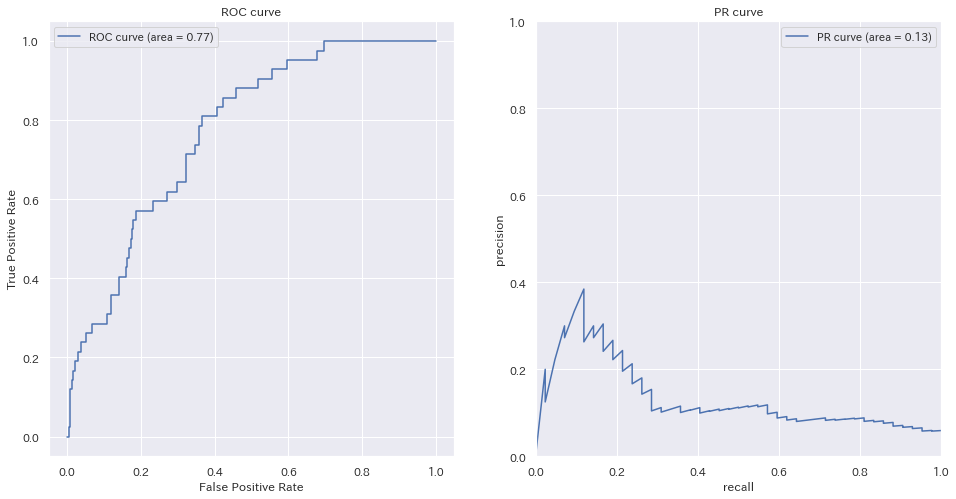

In [180]:
def plot_roc_pr_curve(y_val, y_prob_1):
    fprs, tprs, thresholds_roc = roc_curve(y_val, y_prob_1)
    precisions, recalls, thresholds_pr = precision_recall_curve(y_val, y_prob_1)
    auc_roc = auc(fprs, tprs)
    auc_pr  = auc(recalls, precisions) 

    # ROC曲線
    plt.subplot(1,2,1) 
    plt.plot(fprs, tprs, label='ROC curve (area = %.2f)'%auc_roc)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)

    # PR曲線
    plt.subplot(1,2,2) 
    plt.plot(recalls, precisions, label='PR curve (area = %.2f)'%auc_pr)
    plt.legend()
    plt.title('PR curve')
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.grid(True)

    plt.show()

# ROC曲線、PR曲線の描画
plot_roc_pr_curve(y_val, y_prob_1)

In [181]:
# 予測確率の高い順から並べて、閾値を探る
# 大体0.05くらい？
fprs, tprs, thresholds_roc = roc_curve(y_val, y_prob_1)
df_ft = pd.DataFrame()
df_ft['tprs'] = tprs
df_ft['fprs'] = fprs
df_ft['thresholds_roc'] = thresholds_roc
df_ft

,tprs,fprs,thresholds_roc
0,0.00,0.00,1.45
1,0.00,0.00,0.45
2,0.00,0.00,0.34
3,0.02,0.00,0.33
4,0.02,0.01,0.30
5,0.07,0.01,0.30
6,0.07,0.01,0.29
7,0.12,0.01,0.28
8,0.12,0.01,0.26
9,0.14,0.01,0.26


In [182]:
# 予測確率の高い順から並べて、閾値を探る
df_pred = pd.DataFrame()
df_pred['y_prob_1'] = list(y_prob_1)
df_pred['y_val'] = list(y_val)
# df_pred.sort_values('y_prob_1',ascending=False).query('y_val == 0')
df_pred.sort_values('y_prob_1',ascending=False)

,y_prob_1,y_val
467,0.45,0
533,0.43,0
171,0.36,0
692,0.34,0
15,0.33,1
600,0.33,0
635,0.30,0
308,0.30,0
866,0.30,1
85,0.30,1


# 学習（200K以下）

In [183]:
train_und_200 = train.query('SalePrice <= 200000')

In [184]:
from sklearn.model_selection import KFold
NFOLDS = 5
folds = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=42)
# folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=42) # 対数変換すると層別は使えないっぽい

In [188]:
use_cols = [x for x in train.columns if x not in ['is_up_200','SalePrice','index','Order']]
X = train_und_200[use_cols]
y = train_und_200['SalePrice']
# X_test = test[use_cols]

In [189]:
use_cols

['MS SubClass',
 'MS Zoning',
 'Lot Area',
 'Lot Shape',
 'Land Contour',
 'Lot Config',
 'Neighborhood',
 'Bldg Type',
 'House Style',
 'Overall Qual',
 'Overall Cond',
 'Year Built',
 'Year Remod/Add',
 'Roof Style',
 'Exterior 1st',
 'Exterior 2nd',
 'Exter Qual',
 'Foundation',
 'BsmtFin SF 1',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 'Heating QC',
 'Central Air',
 'Electrical',
 '1st Flr SF',
 '2nd Flr SF',
 'Gr Liv Area',
 'Bsmt Full Bath',
 'Full Bath',
 'Half Bath',
 'Bedroom AbvGr',
 'Kitchen AbvGr',
 'Kitchen Qual',
 'TotRms AbvGrd',
 'Fireplaces',
 'Garage Cars',
 'Garage Area',
 'Paved Drive',
 'Wood Deck SF',
 'Open Porch SF',
 'Mo Sold',
 'Yr Sold',
 'Sale Type',
 'Sale Condition',
 'years_const']

In [190]:
params = {
    'n_jobs': -1,
    'seed': 42,
    'boosting_type': 'gbdt',
    'objective': 'rmse',
#     'num_iteration': 100,           # add
    'metric': 'rmse', # 'rmse'など
#     'eval_metric': 'cappa',
    'feature_fraction':0.998495,    # add
    'bagging_fraction': 0.872417,   # mod 0.8→, = subsample
    'learning_rate': 0.02,
    'feature_fraction': 0.9,        #   = colsample_bytree
    'max_depth': 5,                # mod 10→
    'num_leaves': 1028,             # mod   # 2^max_depth < num_leaves
    'min_gain_to_split':0.085502,   # add
    'min_child_weight':1.087712,    # add
    'lambda_l1': 1,  
    'lambda_l2': 1,
    'verbose': 100,
}

In [191]:
y.value_counts()

158,000.00    587
140,000.00    558
145,000.00    346
130,000.00    222
170,000.00    165
115,000.00    124
110,000.00    120
181,000.00     91
125,000.00     88
153,000.00     55
150,000.00     52
155,000.00     48
135,000.00     44
108,000.00     40
80,000.00      37
185,000.00     35
175,000.00     30
173,000.00     29
188,000.00     25
128,900.00     22
190,000.00     19
185,750.00     17
180,000.00     16
120,000.00     15
139,000.00     12
165,000.00     11
119,164.00      9
178,000.00      8
113,000.00      7
131,000.00      7
169,000.00      6
143,000.00      4
126,000.00      4
192,000.00      3
159,000.00      3
119,000.00      2
154,000.00      2
93,500.00       2
193,000.00      2
82,000.00       2
166,000.00      1
149,700.00      1
176,000.00      1
141,000.00      1
163,000.00      1
139,500.00      1
149,300.00      1
Name: SalePrice, dtype: int64

In [192]:
%%time
import lightgbm as lgb
from sklearn.metrics import *

start_time = time()
models_reg_low = []
scores_reg_low = []

# Train and make models
for fold, (train_ids, val_ids) in enumerate(folds.split(X,y)):

    print('● Fold :', fold+1,'/',NFOLDS)
    train_set = lgb.Dataset(X.iloc[train_ids], y.iloc[train_ids])
    #                       categorical_feature=categorical_features)
    val_set = lgb.Dataset(X.iloc[val_ids], y.iloc[val_ids])

    model = lgb.train(params=params,
                      train_set=train_set,
                      valid_sets=[train_set, val_set],
                      num_boost_round=5000,
                      early_stopping_rounds=100,    # del
                      verbose_eval=200
                     )
    if fold ==0:
        importance_df = pd.DataFrame(model.feature_importance(), index=X.columns, columns=['importance'])
    else:
        importance_df += pd.DataFrame(model.feature_importance(), index=X.columns, columns=['importance'])

    X_val = X.iloc[val_ids]
    y_val = y.iloc[val_ids]
    y_pred = model.predict(X_val)
    # y_pred = np.round(y_prob_1)
    # score = mean_absolute_error(y_val, y_pred)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    print('score : {}'.format(score))

    models_reg_low.append(model)
    scores_reg_low.append(score)
    fold +=1
print('\nTime:', time() - start_time)
print('mean score : {}'.format(sum(scores)/len(scores)))

● Fold : 1 / 5
Training until validation scores don't improve for 100 rounds.
[200]	training's rmse: 13324.4	valid_1's rmse: 16296.6
Early stopping, best iteration is:
[290]	training's rmse: 12659.5	valid_1's rmse: 16229.8
score : 16229.818061214894
● Fold : 2 / 5
Training until validation scores don't improve for 100 rounds.
[200]	training's rmse: 13349.3	valid_1's rmse: 15662.1
[400]	training's rmse: 11769.2	valid_1's rmse: 15645.8
Early stopping, best iteration is:
[302]	training's rmse: 12509.7	valid_1's rmse: 15619.8
score : 15619.81543504156
● Fold : 3 / 5
Training until validation scores don't improve for 100 rounds.
[200]	training's rmse: 13321.1	valid_1's rmse: 16105.2
[400]	training's rmse: 11806	valid_1's rmse: 15997.4
Early stopping, best iteration is:
[439]	training's rmse: 11552.6	valid_1's rmse: 15970.6
score : 15970.572594368286
● Fold : 4 / 5
Training until validation scores don't improve for 100 rounds.
[200]	training's rmse: 13218.1	valid_1's rmse: 16358.4
Early stop

## モデル保存・ロード

In [193]:
# sub_id = '00'

In [194]:
# # 保存
# import pickle
# with open('{}/model/models_sub_{}.pkl'.format(base_dir,sub_id), 'wb') as models_file:
#   pickle.dump(models , models_file)

In [195]:
# # ロード
# import pickle
# with open('{}/model/models_sub_{}.pkl'.format(base_dir,sub_id), 'rb') as models_file:
#   models = pickle.load(models_file)

## 変数重要度

In [196]:
importance_df.sort_values('importance',ascending=False)

,importance
Bsmt Unf SF,2403
BsmtFin SF 1,2378
Bsmt Full Bath,2320
Garage Area,2003
Garage Cars,1948
Total Bsmt SF,1913
Year Built,1474
Lot Area,1257
1st Flr SF,1220
Neighborhood,1194


## 予実分布

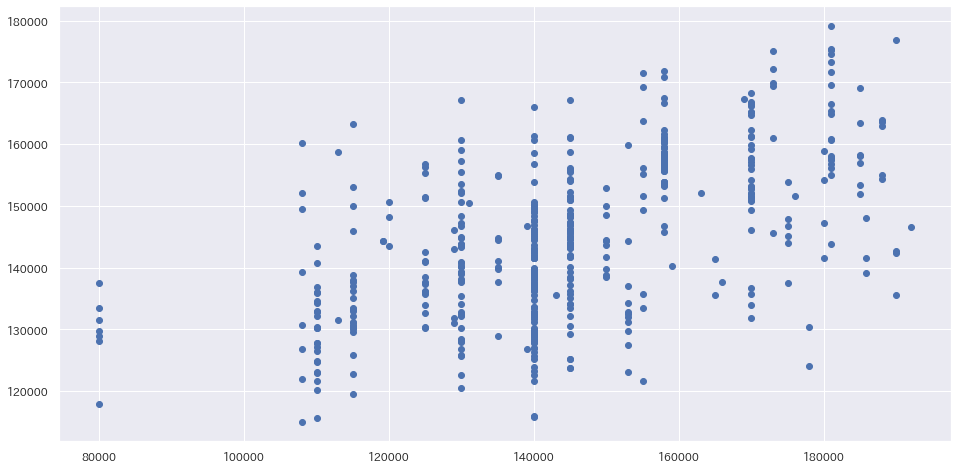

In [197]:
df_pred_tmp = pd.DataFrame()
df_pred_tmp['true'] = y_val
df_pred_tmp['pred'] = y_pred

plt.scatter(df_pred_tmp["true"], df_pred_tmp["pred"])

# fig = px.scatter(df_pred_tmp, x="true", y="pred")
# fig.show()

# 学習（200K超）

In [198]:
train_up_200 = train.query('SalePrice > 200000')

In [207]:
from sklearn.model_selection import KFold
NFOLDS = 3
folds = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=42)
# folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=42) # 対数変換すると層別は使えないっぽい

In [208]:
use_cols = [x for x in train.columns if x not in ['is_up_200','SalePrice','index','Order']]
X = train_up_200[use_cols]
y = train_up_200['SalePrice']
# X_test = test[use_cols]

In [209]:
use_cols

['MS SubClass',
 'MS Zoning',
 'Lot Area',
 'Lot Shape',
 'Land Contour',
 'Lot Config',
 'Neighborhood',
 'Bldg Type',
 'House Style',
 'Overall Qual',
 'Overall Cond',
 'Year Built',
 'Year Remod/Add',
 'Roof Style',
 'Exterior 1st',
 'Exterior 2nd',
 'Exter Qual',
 'Foundation',
 'BsmtFin SF 1',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 'Heating QC',
 'Central Air',
 'Electrical',
 '1st Flr SF',
 '2nd Flr SF',
 'Gr Liv Area',
 'Bsmt Full Bath',
 'Full Bath',
 'Half Bath',
 'Bedroom AbvGr',
 'Kitchen AbvGr',
 'Kitchen Qual',
 'TotRms AbvGrd',
 'Fireplaces',
 'Garage Cars',
 'Garage Area',
 'Paved Drive',
 'Wood Deck SF',
 'Open Porch SF',
 'Mo Sold',
 'Yr Sold',
 'Sale Type',
 'Sale Condition',
 'years_const']

In [210]:
params = {
    'n_jobs': -1,
    'seed': 42,
    'boosting_type': 'gbdt',
    'objective': 'rmse',
#     'num_iteration': 100,           # add
    'metric': 'rmse', # 'rmse'など
#     'eval_metric': 'cappa',
    'feature_fraction':0.998495,    # add
    'bagging_fraction': 0.872417,   # mod 0.8→, = subsample
    'learning_rate': 0.02,
    'feature_fraction': 0.9,        #   = colsample_bytree
    'max_depth': 5,                # mod 10→
    'num_leaves': 1028,             # mod   # 2^max_depth < num_leaves
    'min_gain_to_split':0.085502,   # add
    'min_child_weight':1.087712,    # add
    'lambda_l1': 1,  
    'lambda_l2': 1,
    'verbose': 100,
}

In [211]:
y.value_counts()

290,000.00    38
255,000.00    24
250,000.00    16
219,500.00    15
239,000.00    13
211,000.00     4
235,000.00     3
237,000.00     3
220,000.00     2
320,000.00     2
375,000.00     1
418,000.00     1
232,600.00     1
285,000.00     1
Name: SalePrice, dtype: int64

In [212]:
%%time
import lightgbm as lgb
from sklearn.metrics import *

start_time = time()
models_reg_high = []
scores_reg_high = []

# Train and make models
for fold, (train_ids, val_ids) in enumerate(folds.split(X,y)):

    print('● Fold :', fold+1,'/',NFOLDS)
    train_set = lgb.Dataset(X.iloc[train_ids], y.iloc[train_ids])
    #                       categorical_feature=categorical_features)
    val_set = lgb.Dataset(X.iloc[val_ids], y.iloc[val_ids])

    model = lgb.train(params=params,
                      train_set=train_set,
                      valid_sets=[train_set, val_set],
                      num_boost_round=5000,
                      early_stopping_rounds=100,    # del
                      verbose_eval=200
                     )
    if fold ==0:
        importance_df = pd.DataFrame(model.feature_importance(), index=X.columns, columns=['importance'])
    else:
        importance_df += pd.DataFrame(model.feature_importance(), index=X.columns, columns=['importance'])

    X_val = X.iloc[val_ids]
    y_val = y.iloc[val_ids]
    y_pred = model.predict(X_val)
    # y_pred = np.round(y_prob_1)
    # score = mean_absolute_error(y_val, y_pred)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    print('score : {}'.format(score))

    models_reg_high.append(model)
    scores_reg_high.append(score)
    fold +=1
print('\nTime:', time() - start_time)
print('mean score : {}'.format(sum(scores)/len(scores)))

● Fold : 1 / 3
Training until validation scores don't improve for 100 rounds.
[200]	training's rmse: 22030.7	valid_1's rmse: 23468.7
Early stopping, best iteration is:
[209]	training's rmse: 21825.4	valid_1's rmse: 23456.4
score : 23456.442108915366
● Fold : 2 / 3
Training until validation scores don't improve for 100 rounds.
[200]	training's rmse: 22808.1	valid_1's rmse: 21344.2
Early stopping, best iteration is:
[113]	training's rmse: 25239.5	valid_1's rmse: 20810.7
score : 20810.670824100467
● Fold : 3 / 3
Training until validation scores don't improve for 100 rounds.
[200]	training's rmse: 15375.5	valid_1's rmse: 38354.1
[400]	training's rmse: 12603.9	valid_1's rmse: 37969.8
Early stopping, best iteration is:
[377]	training's rmse: 12831	valid_1's rmse: 37942.4
score : 37942.36536395425

Time: 0.849585771560669
mean score : 0.5304464796090617
CPU times: user 811 ms, sys: 71 ms, total: 882 ms
Wall time: 850 ms


## モデル保存・ロード

In [213]:
# sub_id = '00'

In [214]:
# # 保存
# import pickle
# with open('{}/model/models_sub_{}.pkl'.format(base_dir,sub_id), 'wb') as models_file:
#   pickle.dump(models , models_file)

In [215]:
# # ロード
# import pickle
# with open('{}/model/models_sub_{}.pkl'.format(base_dir,sub_id), 'rb') as models_file:
#   models = pickle.load(models_file)

## 変数重要度

In [216]:
importance_df.sort_values('importance',ascending=False)

,importance
Total Bsmt SF,229
Garage Cars,225
BsmtFin SF 1,188
Year Remod/Add,139
Gr Liv Area,94
Garage Area,89
TotRms AbvGrd,88
Neighborhood,72
MS SubClass,56
Lot Area,54


## 予実分布

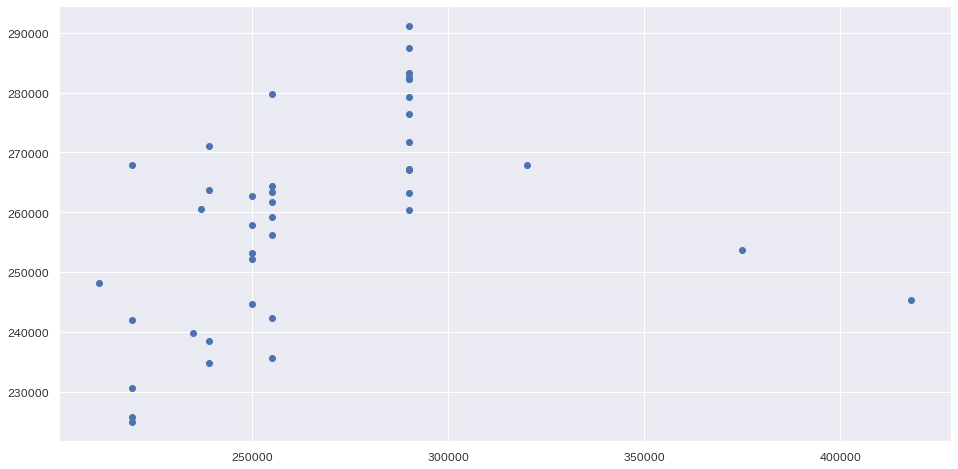

In [217]:
df_pred_tmp = pd.DataFrame()
df_pred_tmp['true'] = y_val
df_pred_tmp['pred'] = y_pred

plt.scatter(df_pred_tmp["true"], df_pred_tmp["pred"])

# fig = px.scatter(df_pred_tmp, x="true", y="pred")
# fig.show()

# 予測・後処理

## 高額か低額かの分類


In [297]:
sub_id = '03'

In [298]:
X_test = test[use_cols]

In [299]:
def pred_clf(models, X_test):
    # 高額か低額かの分類
    preds = []
    for model in models:
        pred = model.predict(X_test,num_iteration=model.best_iteration)
        pred = pred.reshape(len(X_test),1).flatten()
        preds.append(pred)

    pred_df = pd.DataFrame(preds).T
    pred_df['y'] = pred_df.mean(axis= 1)
    pred_df['y'] = pred_df['y'].map(lambda x : 1 if x > 0.05 else 0)
    # pred_df['y'] = np.round(pred_df['y'])
    return pred_df

pred_df_clf = pred_clf(models_clf, X_test)

In [300]:
# pred_df = pd.DataFrame(preds).T
# pred_df['y'] = pred_df.mean(axis= 1)
# pred_df['y'] = pred_df['y'].map(lambda x : 1 if x > 0.05 else 0)
# # pred_df['y'] = np.round(pred_df['y'])

In [301]:
pred_df_clf['index'] = ids

In [302]:
pred_df_clf

,0,1,2,y,index
0,0.02,0.02,0.01,0,398
1,0.05,0.05,0.14,1,3833
2,0.02,0.04,0.05,0,4836
3,0.01,0.01,0.01,0,4572
4,0.01,0.00,0.00,0,636
...,...,...,...,...,...
1995,0.07,0.10,0.04,1,3138
1996,0.02,0.04,0.03,0,191
1997,0.01,0.03,0.01,0,3294
1998,0.02,0.05,0.02,0,3073


## 高額の予測


In [303]:
id_high = pred_df_clf.query('y == 1')['index']
X_test = pd.merge(test, id_high, how='inner', on='index')[use_cols]

In [304]:
def pred_reg(models, X_test):
    # 高額か低額かの分類
    preds = []
    for model in models:
        pred = model.predict(X_test,num_iteration=model.best_iteration)
        pred = pred.reshape(len(X_test),1).flatten()
        preds.append(pred)

    pred_df = pd.DataFrame(preds).T
    pred_df['y'] = pred_df.mean(axis= 1)
    # pred_df['y'] = pred_df['y'].map(lambda x : 1 if x > 0.05 else 0)
    # pred_df['y'] = np.round(pred_df['y'])
    return pred_df

pred_df_reg_high = pred_reg(models_reg_high, X_test)

In [305]:
pred_df_reg_high ['index'] = list(id_high)

In [306]:
pred_df_reg_high = pred_df_reg_high[['index','y']]

In [307]:
pred_df_reg_high.head()

,index,y
0,3833,"266,922.63"
1,4070,"270,802.90"
2,1261,"246,995.83"
3,453,"265,899.79"
4,2550,"234,356.49"


## 低額の予測


In [308]:
id_low = pred_df_clf.query('y == 0')['index']
X_test = pd.merge(test, id_low, how='inner', on='index')[use_cols]

In [309]:
def pred_reg(models, X_test):
    preds = []
    for model in models:
        pred = model.predict(X_test,num_iteration=model.best_iteration)
        pred = pred.reshape(len(X_test),1).flatten()
        preds.append(pred)

    pred_df = pd.DataFrame(preds).T
    pred_df['y'] = pred_df.mean(axis= 1)
    # pred_df['y'] = pred_df['y'].map(lambda x : 1 if x > 0.05 else 0)
    # pred_df['y'] = np.round(pred_df['y'])
    return pred_df

pred_df_reg_low = pred_reg(models_reg_low, X_test)

In [310]:
pred_df_reg_low ['index'] = list(id_low)

In [311]:
pred_df_reg_low = pred_df_reg_low[['index','y']]

In [312]:
pred_df_reg_low

,index,y
0,398,"152,053.33"
1,4836,"145,819.34"
2,4572,"148,153.92"
3,636,"158,283.49"
4,2545,"158,472.21"
...,...,...
1525,1451,"137,905.10"
1526,191,"159,274.42"
1527,3294,"141,002.57"
1528,3073,"135,871.29"


## 予測結果マージ、サブミット


In [315]:
pred_df = pd.concat([pred_df_reg_high,pred_df_reg_low], axis=0)

In [327]:
pred_df = pd.merge(sample_submit, pred_df, how='inner', on='index')

In [328]:
submission = pd.DataFrame({"index": pred_df['index'], "Predicted": pred_df['y']})
submission.to_csv('{}/output/submission_{}.csv'.format(base_dir,sub_id),index=False,header=False)

In [329]:
submission

,index,Predicted
0,398,"152,053.33"
1,3833,"266,922.63"
2,4836,"145,819.34"
3,4572,"148,153.92"
4,636,"158,283.49"
...,...,...
1995,3138,"271,886.24"
1996,191,"159,274.42"
1997,3294,"141,002.57"
1998,3073,"135,871.29"


# 予測結果のトレンド確認

## 描画前処理

In [ ]:
# sub_id = '05'
# base_dir = '/content/drive/MyDrive/work/Kaggle/DataRobot_TimeSeries_Modeling'

In [ ]:
submission = pd.read_csv('{}/output/submission_{}.csv'.format(base_dir,sub_id))

calendar = pd.read_csv('{}/input/calendar.csv'.format(base_dir)) 
predict_kia = pd.read_csv('{}/input/predict_kia.csv'.format(base_dir)) 
sample_submission = pd.read_csv('{}/input/sample_submission.csv'.format(base_dir)) 
train = pd.read_csv('{}/input/train.csv'.format(base_dir)) 

In [ ]:
test = submission

test['Date'] = test['Id'].str.split('_', expand=True)[0]
test['store_id'] = test['Id'].str.split('_', expand=True)[1]
test['prod_id'] = test['Id'].str.split('_', expand=True)[2]

test = test.rename(columns={'Predicted':'Sales_qty'})

In [ ]:
train['is_train'] = 1
test['is_train'] = 0
df = pd.concat([train,test],axis=0)

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df_sum = df.groupby('Date').agg({'Sales_qty':'sum'}).reset_index()

In [ ]:
df_sum['year'] = df_sum['Date'].dt.year
df_sum['month'] = df_sum['Date'].dt.month
df_sum['day'] = df_sum['Date'].dt.day

# month_dayを作るために一時的に文字列型に変換
df_sum['month'] = df_sum['month'].astype('str')
df_sum['day'] = df_sum['day'].astype('str')
df_sum['month_day'] = df_sum['month'] + '-' + df_sum['day']
df_sum['Date_2'] = '2000-' + df_sum['month'] + '-' + df_sum['day'] # 年は何でもいい。月日揃えて年別比較したいだけなので
df_sum['Date_2'] = pd.to_datetime(df_sum['Date_2'])
df_sum['month'] = df_sum['month'].astype('int')
df_sum['day'] = df_sum['day'].astype('int')

## トレンド描画

In [ ]:
# 全期間描画
fig = px.line(df_sum, x="Date_2", y="Sales_qty", color="year")
fig.show()

In [ ]:
# 10月〜12月だけ描画
df_sum_tmp = df_sum.query('10 <= month <= 12')
fig = px.line(df_sum_tmp, x="Date_2", y="Sales_qty", color="year")
fig.show()

In [ ]:
# カレンダー結合
calendar['Date'] = pd.to_datetime(calendar['Date'])
df_sum = pd.merge(df_sum, calendar, how='left', on='Date')

In [ ]:
# ファイル出力
df_sum.query('"2014-11-01" <= Date <= "2014-12-31"').to_csv('{}/output/submission_{}_agged.csv'.format(base_dir,sub_id), index=False)

In [ ]:
test

,Id,Sales_qty,Date,store_id,prod_id,is_train
0,2014-11-01_s1_p1,4.08,2014-11-01,s1,p1,0
1,2014-11-01_s2_p1,8.39,2014-11-01,s2,p1,0
2,2014-11-01_s3_p1,5.82,2014-11-01,s3,p1,0
3,2014-11-01_s4_p1,1.70,2014-11-01,s4,p1,0
4,2014-11-01_s5_p1,3.67,2014-11-01,s5,p1,0
...,...,...,...,...,...,...
14635,2014-12-31_s6_p4,2.36,2014-12-31,s6,p4,0
14636,2014-12-31_s7_p4,2.19,2014-12-31,s7,p4,0
14637,2014-12-31_s8_p4,1.25,2014-12-31,s8,p4,0
14638,2014-12-31_s9_p4,1.99,2014-12-31,s9,p4,0


## 店舗別

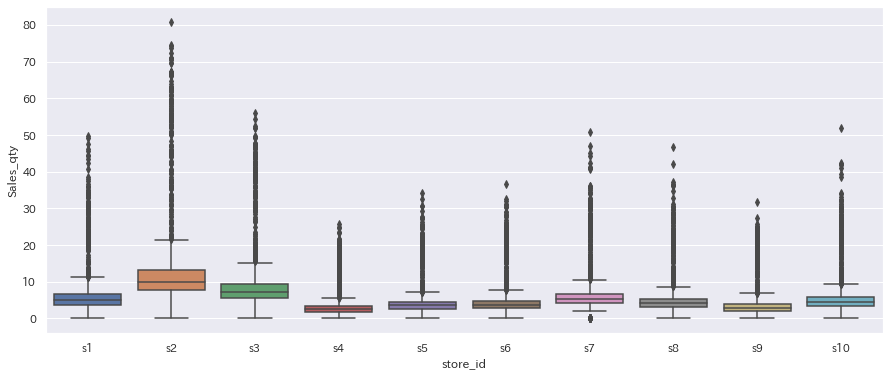

In [ ]:
# 店舗別分布
sns.boxplot(x= 'store_id', y= 'Sales_qty', data= test)

In [ ]:
# 店舗別トレンド
df_sum_store = df.groupby(['Date','store_id']).agg({'Sales_qty':'sum'}).reset_index()
df_sum_store = proc_date(df_sum_store)
stores = df['store_id'].unique()

for s in stores:
    df_tmp = df_sum_store.query('store_id == @s')
    df_tmp = df_sum_store.query('store_id == @s and 9 <= month <= 12')
    fig = px.line(df_tmp, x="Date_2", y="Sales_qty", color="year", title=s)
    fig.show()

In [ ]:
df_sum_store

,Date,store_id,Sales_qty,year,month,day,weekday,year_month,month_day,Date_2,bf_year,bf_month,bf_month_2,bf_ymd,bf_year_month,nth_week
0,2012-04-01,s1,157.00,2012,4,1,6,2012-04,04-01,2000-04-01,2011,2012-03,2012-02,2011-04-01,2011-04,1
1,2012-04-01,s10,43.00,2012,4,1,6,2012-04,04-01,2000-04-01,2011,2012-03,2012-02,2011-04-01,2011-04,1
2,2012-04-01,s2,302.00,2012,4,1,6,2012-04,04-01,2000-04-01,2011,2012-03,2012-02,2011-04-01,2011-04,1
3,2012-04-01,s3,102.00,2012,4,1,6,2012-04,04-01,2000-04-01,2011,2012-03,2012-02,2011-04-01,2011-04,1
4,2012-04-01,s4,43.00,2012,4,1,6,2012-04,04-01,2000-04-01,2011,2012-03,2012-02,2011-04-01,2011-04,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10045,2014-12-31,s5,113.23,2014,12,31,2,2014-12,12-31,2000-12-31,2013,2014-11,2014-10,2013-12-31,2013-12,5
10046,2014-12-31,s6,137.88,2014,12,31,2,2014-12,12-31,2000-12-31,2013,2014-11,2014-10,2013-12-31,2013-12,5
10047,2014-12-31,s7,138.56,2014,12,31,2,2014-12,12-31,2000-12-31,2013,2014-11,2014-10,2013-12-31,2013-12,5
10048,2014-12-31,s8,111.44,2014,12,31,2,2014-12,12-31,2000-12-31,2013,2014-11,2014-10,2013-12-31,2013-12,5


## 商品別

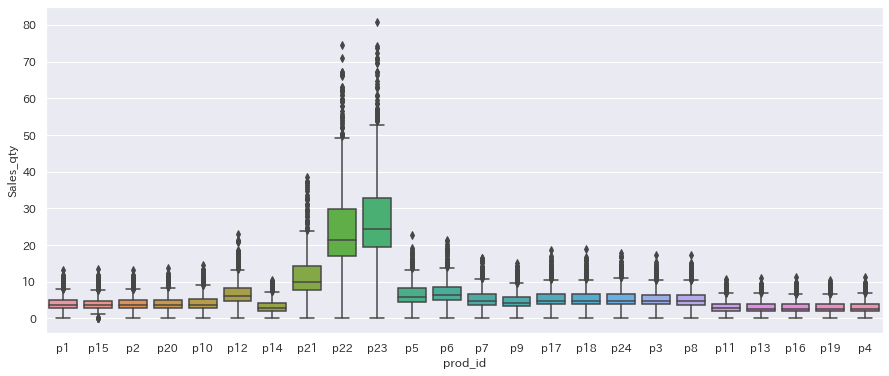

In [ ]:
# 商品別
sns.boxplot(x= 'prod_id', y= 'Sales_qty', data= test)

## 店舗・商品別

### p1

In [ ]:
# 日付処理
df = proc_date(df)

In [ ]:
# p1のトレンド
p = 'p1'
stores = df['store_id'].unique()

for s in stores:
    df_tmp = df.query('store_id == @s and prod_id == @p and 10 <= month <= 12')
    # df_tmp = df.query('store_id == @s and prod_id == @p')
    fig = px.line(df_tmp, x="Date_2", y="Sales_qty", color="year", title=s)
    fig.show()